In [1]:
from omegaconf import OmegaConf
import numpy as np
import pickle as pkl
import torch
import sys
sys.path.append("/dreambig/qingyi/stable-diffusion")
  
# from dataloader import image_loader
# from ldm.data.satellite import SatelliteTrain, SatelliteValidation
# from main import DataModuleFromConfig
from ldm.util import instantiate_from_config

from setup import *
from scripts.img2img import load_model_from_config

%load_ext autoreload
%autoreload 2

In [2]:
version = '2023-07-01T01-54-38'
epoch = 329
epoch = f"{epoch:06d}"

# ckpt = '/dreambig/qingyi/stable-diffusion/logs/2023-06-28T22-03-37_sae_8x8x64/checkpoints/epoch=000160.ckpt'
# ckpt = '/dreambig/qingyi/stable-diffusion/logs/2023-06-28T22-01-34_sae_8x8x64/checkpoints/epoch=000277.ckpt'
# ckpt = '/dreambig/qingyi/stable-diffusion/logs/2023-06-28T22-04-35_sae_8x8x64/checkpoints/epoch=000239.ckpt'
# ckpt = '/dreambig/qingyi/stable-diffusion/logs/2023-06-30T01-32-58_sae_8x8x64/checkpoints/epoch=000088.ckpt'
# ckpt = '/dreambig/qingyi/stable-diffusion/logs/2023-06-30T02-17-21_sae_8x8x64/checkpoints/epoch=000106.ckpt'
# ckpt = '/dreambig/qingyi/stable-diffusion/logs/2023-07-01T01-02-43_sae_8x8x64/checkpoints/epoch=000670.ckpt'
ckpt = '/dreambig/qingyi/stable-diffusion/logs/'+version+'_sae_8x8x64/checkpoints/epoch='+epoch+'.ckpt'

config = OmegaConf.load('/dreambig/qingyi/stable-diffusion/logs/'+version+'_sae_8x8x64/configs/'+version+'-project.yaml')
device = torch.device("cuda:2") if torch.cuda.is_available() else torch.device("cpu")
model = load_model_from_config(config, ckpt, verbose=True, device=2)


Loading model from /dreambig/qingyi/stable-diffusion/logs/2023-07-01T01-54-38_sae_8x8x64/checkpoints/epoch=000329.ckpt
Global Step: 295020
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth


In [3]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 51821324


In [14]:
data = instantiate_from_config(config.data)
data.prepare_data()
data.setup()

train_loader = data._train_dataloader()
test_loader = data._val_dataloader()

/home/jtl/anaconda3/envs/ldm/lib/python3.8/site-packages/torch/utils/data/dataloader.py:487: UserWarning: This DataLoader will create 64 worker processes in total. Our suggested max number of worker in current system is 20, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [16]:
ct = []
encoder_output = []
im = []
sup_true_list = []
sup_list = []

for step, batch in enumerate(test_loader):
    
    inputs, sup_true = model.get_input(batch, 'image', 'condition')
    inputs = inputs.to(device)
    z = model.encode(inputs)
    sup = model.supervisor(z)
    
    encoder_output += [z.cpu().detach().numpy()]
    ct += [s[s.rindex("/")+1: s.rindex("_")] for s in batch['image_path']]
    im += batch['image_path']
    sup_true_list += [sup_true.cpu().detach().numpy()]
    sup_list += [sup.cpu().detach().numpy()]
    
    if step % 100 == 0:
        print(step, end='\t')
        
for step, batch in enumerate(train_loader):
    
    inputs, sup_true = model.get_input(batch, 'image', 'condition')
    inputs = inputs.to(device)
    z = model.encode(inputs)
    sup = model.supervisor(z)
    
    encoder_output += [z.cpu().detach().numpy()]
    ct += [s[s.rindex("/")+1: s.rindex("_")] for s in batch['image_path']]
    im += batch['image_path']
    sup_true_list += [sup_true.cpu().detach().numpy()]
    sup_list += [sup.cpu().detach().numpy()]
 
    if step % 100 == 0:
        print(step, end='\t')
        

/dreambig/qingyi/stable-diffusion/src/taming-transformers/taming/data/utils.py:137: UserWarning: An output with one or more elements was resized since it had shape [4816896], which does not match the required output shape [32, 224, 224, 3].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/Resize.cpp:24.)
  return torch.stack(batch, 0, out=out)
/dreambig/qingyi/stable-diffusion/src/taming-transformers/taming/data/utils.py:137: UserWarning: An output with one or more elements was resized since it had shape [320], which does not match the required output shape [32, 10].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor

/dreambig/qingyi/stable-diffusion/src/taming-transformers/taming/data/utils.py:137: UserWarning: An output with one or more elements was resized since it had shape [320], which does not match the required output shape [32, 10].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/Resize.cpp:24.)
  return torch.stack(batch, 0, out=out)
/dreambig/qingyi/stable-diffusion/src/taming-transformers/taming/data/utils.py:137: UserWarning: An output with one or more elements was resized since it had shape [320], which does not match the required output shape [32, 10].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizin

/dreambig/qingyi/stable-diffusion/src/taming-transformers/taming/data/utils.py:137: UserWarning: An output with one or more elements was resized since it had shape [4816896], which does not match the required output shape [32, 224, 224, 3].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/Resize.cpp:24.)
  return torch.stack(batch, 0, out=out)
/dreambig/qingyi/stable-diffusion/src/taming-transformers/taming/data/utils.py:137: UserWarning: An output with one or more elements was resized since it had shape [4816896], which does not match the required output shape [32, 224, 224, 3].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse 

/dreambig/qingyi/stable-diffusion/src/taming-transformers/taming/data/utils.py:137: UserWarning: An output with one or more elements was resized since it had shape [320], which does not match the required output shape [32, 10].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/Resize.cpp:24.)
  return torch.stack(batch, 0, out=out)
/dreambig/qingyi/stable-diffusion/src/taming-transformers/taming/data/utils.py:137: UserWarning: An output with one or more elements was resized since it had shape [320], which does not match the required output shape [32, 10].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizin

/dreambig/qingyi/stable-diffusion/src/taming-transformers/taming/data/utils.py:137: UserWarning: An output with one or more elements was resized since it had shape [4816896], which does not match the required output shape [32, 224, 224, 3].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/Resize.cpp:24.)
  return torch.stack(batch, 0, out=out)
/dreambig/qingyi/stable-diffusion/src/taming-transformers/taming/data/utils.py:137: UserWarning: An output with one or more elements was resized since it had shape [4816896], which does not match the required output shape [32, 224, 224, 3].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse 

/dreambig/qingyi/stable-diffusion/src/taming-transformers/taming/data/utils.py:137: UserWarning: An output with one or more elements was resized since it had shape [320], which does not match the required output shape [32, 10].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/Resize.cpp:24.)
  return torch.stack(batch, 0, out=out)
/dreambig/qingyi/stable-diffusion/src/taming-transformers/taming/data/utils.py:137: UserWarning: An output with one or more elements was resized since it had shape [320], which does not match the required output shape [32, 10].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizin

/dreambig/qingyi/stable-diffusion/src/taming-transformers/taming/data/utils.py:137: UserWarning: An output with one or more elements was resized since it had shape [320], which does not match the required output shape [32, 10].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/Resize.cpp:24.)
  return torch.stack(batch, 0, out=out)
/dreambig/qingyi/stable-diffusion/src/taming-transformers/taming/data/utils.py:137: UserWarning: An output with one or more elements was resized since it had shape [320], which does not match the required output shape [32, 10].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizin

/dreambig/qingyi/stable-diffusion/src/taming-transformers/taming/data/utils.py:137: UserWarning: An output with one or more elements was resized since it had shape [4816896], which does not match the required output shape [32, 224, 224, 3].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/Resize.cpp:24.)
  return torch.stack(batch, 0, out=out)
/dreambig/qingyi/stable-diffusion/src/taming-transformers/taming/data/utils.py:137: UserWarning: An output with one or more elements was resized since it had shape [4816896], which does not match the required output shape [32, 224, 224, 3].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse 

/dreambig/qingyi/stable-diffusion/src/taming-transformers/taming/data/utils.py:137: UserWarning: An output with one or more elements was resized since it had shape [320], which does not match the required output shape [32, 10].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/Resize.cpp:24.)
  return torch.stack(batch, 0, out=out)
/dreambig/qingyi/stable-diffusion/src/taming-transformers/taming/data/utils.py:137: UserWarning: An output with one or more elements was resized since it had shape [320], which does not match the required output shape [32, 10].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizin

/dreambig/qingyi/stable-diffusion/src/taming-transformers/taming/data/utils.py:137: UserWarning: An output with one or more elements was resized since it had shape [4816896], which does not match the required output shape [32, 224, 224, 3].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/Resize.cpp:24.)
  return torch.stack(batch, 0, out=out)
/dreambig/qingyi/stable-diffusion/src/taming-transformers/taming/data/utils.py:137: UserWarning: An output with one or more elements was resized since it had shape [320], which does not match the required output shape [32, 10].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor

0	

/dreambig/qingyi/stable-diffusion/src/taming-transformers/taming/data/utils.py:137: UserWarning: An output with one or more elements was resized since it had shape [4816896], which does not match the required output shape [32, 224, 224, 3].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/Resize.cpp:24.)
  return torch.stack(batch, 0, out=out)
/dreambig/qingyi/stable-diffusion/src/taming-transformers/taming/data/utils.py:137: UserWarning: An output with one or more elements was resized since it had shape [320], which does not match the required output shape [32, 10].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor

0	

/dreambig/qingyi/stable-diffusion/src/taming-transformers/taming/data/utils.py:137: UserWarning: An output with one or more elements was resized since it had shape [4816896], which does not match the required output shape [32, 224, 224, 3].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/Resize.cpp:24.)
  return torch.stack(batch, 0, out=out)
/dreambig/qingyi/stable-diffusion/src/taming-transformers/taming/data/utils.py:137: UserWarning: An output with one or more elements was resized since it had shape [4816896], which does not match the required output shape [32, 224, 224, 3].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse 

/dreambig/qingyi/stable-diffusion/src/taming-transformers/taming/data/utils.py:137: UserWarning: An output with one or more elements was resized since it had shape [320], which does not match the required output shape [32, 10].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/Resize.cpp:24.)
  return torch.stack(batch, 0, out=out)
/dreambig/qingyi/stable-diffusion/src/taming-transformers/taming/data/utils.py:137: UserWarning: An output with one or more elements was resized since it had shape [4816896], which does not match the required output shape [32, 224, 224, 3].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor

/dreambig/qingyi/stable-diffusion/src/taming-transformers/taming/data/utils.py:137: UserWarning: An output with one or more elements was resized since it had shape [4816896], which does not match the required output shape [32, 224, 224, 3].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/Resize.cpp:24.)
  return torch.stack(batch, 0, out=out)
/dreambig/qingyi/stable-diffusion/src/taming-transformers/taming/data/utils.py:137: UserWarning: An output with one or more elements was resized since it had shape [320], which does not match the required output shape [32, 10].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor

/dreambig/qingyi/stable-diffusion/src/taming-transformers/taming/data/utils.py:137: UserWarning: An output with one or more elements was resized since it had shape [4816896], which does not match the required output shape [32, 224, 224, 3].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/Resize.cpp:24.)
  return torch.stack(batch, 0, out=out)
/dreambig/qingyi/stable-diffusion/src/taming-transformers/taming/data/utils.py:137: UserWarning: An output with one or more elements was resized since it had shape [4816896], which does not match the required output shape [32, 224, 224, 3].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse 

/dreambig/qingyi/stable-diffusion/src/taming-transformers/taming/data/utils.py:137: UserWarning: An output with one or more elements was resized since it had shape [320], which does not match the required output shape [32, 10].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/Resize.cpp:24.)
  return torch.stack(batch, 0, out=out)
/dreambig/qingyi/stable-diffusion/src/taming-transformers/taming/data/utils.py:137: UserWarning: An output with one or more elements was resized since it had shape [320], which does not match the required output shape [32, 10].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizin

/dreambig/qingyi/stable-diffusion/src/taming-transformers/taming/data/utils.py:137: UserWarning: An output with one or more elements was resized since it had shape [4816896], which does not match the required output shape [32, 224, 224, 3].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/Resize.cpp:24.)
  return torch.stack(batch, 0, out=out)
/dreambig/qingyi/stable-diffusion/src/taming-transformers/taming/data/utils.py:137: UserWarning: An output with one or more elements was resized since it had shape [4816896], which does not match the required output shape [32, 224, 224, 3].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse 

/dreambig/qingyi/stable-diffusion/src/taming-transformers/taming/data/utils.py:137: UserWarning: An output with one or more elements was resized since it had shape [320], which does not match the required output shape [32, 10].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/Resize.cpp:24.)
  return torch.stack(batch, 0, out=out)
/dreambig/qingyi/stable-diffusion/src/taming-transformers/taming/data/utils.py:137: UserWarning: An output with one or more elements was resized since it had shape [320], which does not match the required output shape [32, 10].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizin

/dreambig/qingyi/stable-diffusion/src/taming-transformers/taming/data/utils.py:137: UserWarning: An output with one or more elements was resized since it had shape [4816896], which does not match the required output shape [32, 224, 224, 3].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/Resize.cpp:24.)
  return torch.stack(batch, 0, out=out)
/dreambig/qingyi/stable-diffusion/src/taming-transformers/taming/data/utils.py:137: UserWarning: An output with one or more elements was resized since it had shape [320], which does not match the required output shape [32, 10].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor

/dreambig/qingyi/stable-diffusion/src/taming-transformers/taming/data/utils.py:137: UserWarning: An output with one or more elements was resized since it had shape [4816896], which does not match the required output shape [32, 224, 224, 3].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/Resize.cpp:24.)
  return torch.stack(batch, 0, out=out)
/dreambig/qingyi/stable-diffusion/src/taming-transformers/taming/data/utils.py:137: UserWarning: An output with one or more elements was resized since it had shape [4816896], which does not match the required output shape [32, 224, 224, 3].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse 

100	

Process Process-127:
Process Process-113:
Process Process-125:
Process Process-126:
Process Process-124:
Process Process-65:
Process Process-119:
Process Process-123:
Process Process-122:
Process Process-108:
Process Process-107:
Traceback (most recent call last):
Process Process-121:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-118:
Traceback (most recent call last):
  File "/home/jtl/anaconda3/envs/ldm/lib/python3.8/multiprocessing/process.py", line 318, in _bootstrap
    util._exit_function()
Traceback (most recent call last):
Process Process-128:
Process Process-120:
  File "/home/jtl/anaconda3/envs/ldm/lib/python3.8/multiprocessing/process.py", line 318, in _bootstrap
    util._exit_function()
  File "/home/jtl/anaconda3/envs/ldm/lib/python3.8/multiprocessing/process.py", line 318, in _bootstrap
    util._exit_function()
Traceback (most recent call last):
  File "/home/jtl/anaconda3/envs/ldm/lib/python3.8/

KeyboardInterrupt: 

In [18]:
encoder_output = np.vstack(encoder_output)  

In [19]:
encoder_output.shape

(31760, 2048)

In [38]:
with open(proj_dir+"latent_space/"+version+"_sae_"+
          str(config['model']['params']['ddconfig']['output_dim'])+"_"+
          str(config['model']['params']['lossconfig']['params']['supervision_factor'])+
          "_ep"+epoch.lstrip('0')+".pkl", "wb") as f:

    pkl.dump(encoder_output, f)
    pkl.dump(im, f)
    pkl.dump(ct, f)
    pkl.dump(sup_true_list, f)
    pkl.dump(sup_list, f)

In [46]:
print(version+"_sae_"+
          str(config['model']['params']['ddconfig']['output_dim'])+"_"+
          str(config['model']['params']['lossconfig']['params']['supervision_factor'])+
          "_ep"+epoch.lstrip('0')+".pkl")

2023-07-01T01-54-38_sae_1_0.5_ep329.pkl


In [39]:
with open(proj_dir+"latent_space/"+version+"_sae_"+
          str(config['model']['params']['ddconfig']['output_dim'])+"_"+
          str(config['model']['params']['lossconfig']['params']['supervision_factor'])+
          "_ep"+epoch.lstrip('0')+".pkl", "rb") as f:
    pkl.load(f)
    pkl.load(f)
    pkl.load(f)
    sup_true_list = pkl.load(f)
    sup_list = pkl.load(f)
    

In [40]:
sup_true_list = np.concatenate(sup_true_list)
sup_list = np.concatenate(sup_list)
sup_true_list = sup_true_list[:3176]
sup_list = sup_list[:3176]

In [41]:
from sklearn.metrics import r2_score

r2 = r2_score(sup_true_list, sup_list, multioutput='raw_values')

In [42]:
xlabels = ['pop density','pct25-34yrs','pct35-50yrs','pct over65yrs',
                 'pct white','pct non-white','pct black',
                 'pct col grad','avg tt to work','income']

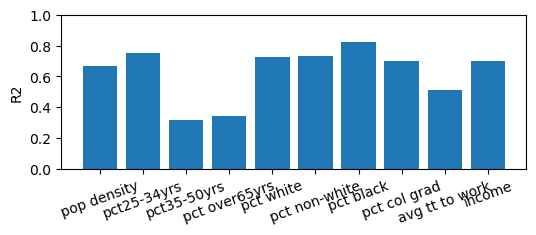

In [44]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6,2))
ax.bar(x = np.arange(10), height=r2)
ax.set_xticks(np.arange(10))
ax.set_xticklabels(xlabels, rotation=20);
ax.set_ylim([0,1])
ax.set_ylabel('R2')
fig.savefig(out_dir+"SVAE/"+version+"_sae_"+str(config['model']['params']['ddconfig']['output_dim'])+"_"+
          str(config['model']['params']['lossconfig']['params']['supervision_factor'])+
          "_ep"+epoch.lstrip('0')+".png", bbox_inches='tight')

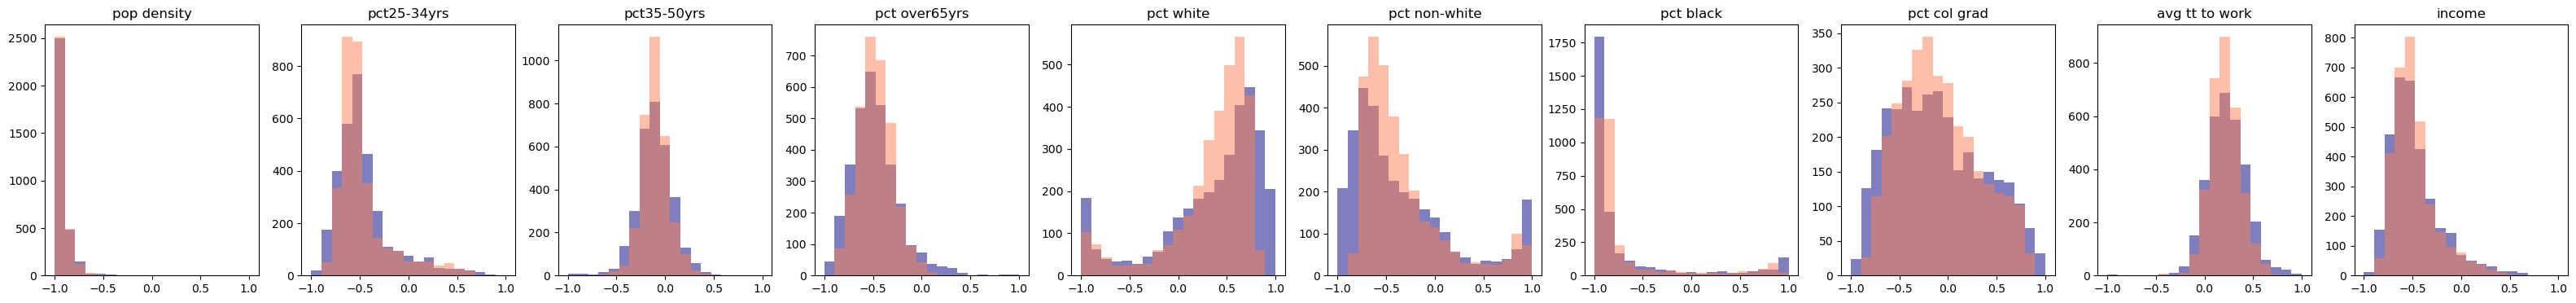

In [45]:
fig, ax = plt.subplots(1,10, figsize=(40,4))
for i,j,c in zip(np.arange(10), np.arange(10), xlabels):
    ax[i].hist(sup_true_list[:,j], bins=np.linspace(-1,1,20), alpha=0.5, color='navy')
    ax[i].hist(sup_list[:,j], bins=np.linspace(-1,1,20), alpha=0.5, color='coral')
    ax[i].set_title(c)

In [4]:
for step, batch in enumerate(test_loader):
    
    inputs, sup_true = model.get_input(batch, 'image', 'condition')
    inputs = inputs.to(device)
    z = model.encode(inputs)
    
    break

/dreambig/qingyi/stable-diffusion/src/taming-transformers/taming/data/utils.py:137: UserWarning: An output with one or more elements was resized since it had shape [2408448], which does not match the required output shape [16, 224, 224, 3].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/Resize.cpp:24.)
  return torch.stack(batch, 0, out=out)
/dreambig/qingyi/stable-diffusion/src/taming-transformers/taming/data/utils.py:137: UserWarning: An output with one or more elements was resized since it had shape [160], which does not match the required output shape [16, 10].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor

/dreambig/qingyi/stable-diffusion/src/taming-transformers/taming/data/utils.py:137: UserWarning: An output with one or more elements was resized since it had shape [2408448], which does not match the required output shape [16, 224, 224, 3].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/Resize.cpp:24.)
  return torch.stack(batch, 0, out=out)
/dreambig/qingyi/stable-diffusion/src/taming-transformers/taming/data/utils.py:137: UserWarning: An output with one or more elements was resized since it had shape [160], which does not match the required output shape [16, 10].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor

/dreambig/qingyi/stable-diffusion/src/taming-transformers/taming/data/utils.py:137: UserWarning: An output with one or more elements was resized since it had shape [2408448], which does not match the required output shape [16, 224, 224, 3].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/Resize.cpp:24.)
  return torch.stack(batch, 0, out=out)
/dreambig/qingyi/stable-diffusion/src/taming-transformers/taming/data/utils.py:137: UserWarning: An output with one or more elements was resized since it had shape [2408448], which does not match the required output shape [16, 224, 224, 3].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse 

/dreambig/qingyi/stable-diffusion/src/taming-transformers/taming/data/utils.py:137: UserWarning: An output with one or more elements was resized since it had shape [160], which does not match the required output shape [16, 10].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/Resize.cpp:24.)
  return torch.stack(batch, 0, out=out)
/dreambig/qingyi/stable-diffusion/src/taming-transformers/taming/data/utils.py:137: UserWarning: An output with one or more elements was resized since it had shape [2408448], which does not match the required output shape [16, 224, 224, 3].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor

/dreambig/qingyi/stable-diffusion/src/taming-transformers/taming/data/utils.py:137: UserWarning: An output with one or more elements was resized since it had shape [2408448], which does not match the required output shape [16, 224, 224, 3].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/Resize.cpp:24.)
  return torch.stack(batch, 0, out=out)
/dreambig/qingyi/stable-diffusion/src/taming-transformers/taming/data/utils.py:137: UserWarning: An output with one or more elements was resized since it had shape [2408448], which does not match the required output shape [16, 224, 224, 3].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse 

In [23]:
import matplotlib.pyplot as plt
import torchvision
from PIL import Image

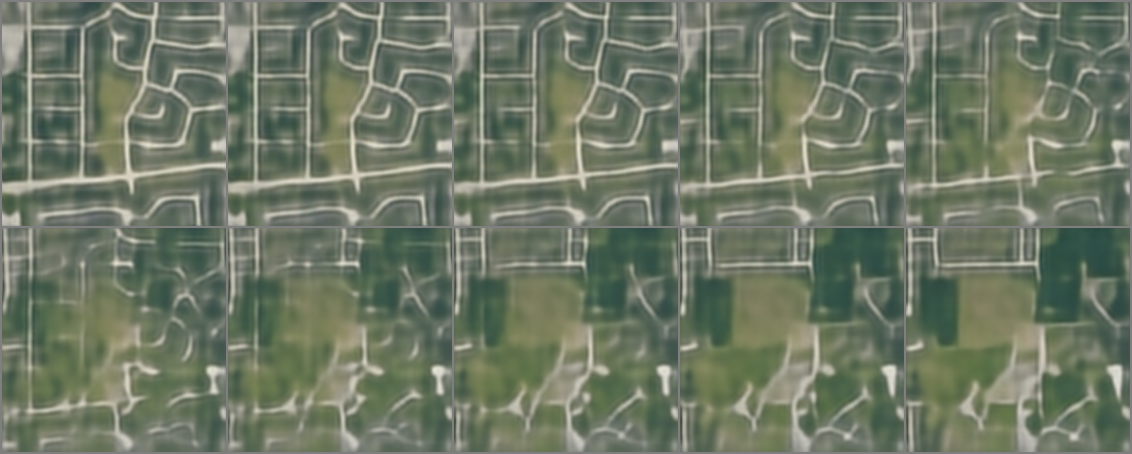

In [30]:
z1 = z[0,:]
z2 = z[1,:]

mult_list = np.arange(0,1,0.1)

grid = []

for i in mult_list:
    z_int = i * z1 + (1-i) * z2
    z_int = z_int.to(device).view(1,-1)
    img_int = model.decode(z_int)
    img_int = img_int.cpu().detach().squeeze()
    grid.append(img_int)
    
grid = torchvision.utils.make_grid(grid, nrow=5)
grid = (grid + 1.0) / 2.0  # -1,1 -> 0,1; c,h,w
grid = grid.transpose(0, 1).transpose(1, 2).squeeze(-1)
grid = grid.numpy()
grid = (grid * 255).astype(np.uint8)
Image.fromarray(grid)